In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Configure plotting style for professional reports
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'lines.linewidth': 2
})

In [7]:
class SystemParameters:
    def __init__(self):
        # Nominal Ratings
        self.Sn = 100e3       # Nominal Apparent Power (VA)
        self.Vn = 400         # Nominal Voltage (V line-line rms)
        self.fn = 60.0        # Nominal Frequency (Hz)
        self.wn = 2 * np.pi * self.fn
        
        # Load Parameters (RLC Load)
        # Designed to consume 0.8 pu Active and 0.1 pu Reactive at nominal voltage
        self.P_load_pu = 0.8
        self.Q_load_pu = 0.1
        
        # GFM Droop Coefficients
        # 1% frequency droop for 1.0 pu power change
        self.mp = (0.01 * self.wn) / 1.0 
        # 5% voltage droop for 1.0 pu reactive power change
        self.nq = (0.05 * 1.0) / 1.0 
        
        # Low Pass Filter Time Constant (for power measurement)
        self.tau_p = 0.05  # 50ms
        
        # GFL PLL Parameters (Instability simulation factors)
        self.Kp_pll = 0.5
        self.Ki_pll = 10.0

params = SystemParameters()

In [8]:
def gfm_dynamics(t, state, p, islanded):
    """
    Differential equations for Grid-Forming Inverter (Droop Control).
    State vector: [theta (rad), P_meas (pu), Q_meas (pu)]
    """
    theta, P_meas, Q_meas = state
    
    # 1. Determine Grid Interaction
    if not islanded:
        # Grid is stiff: Frequency is fixed at nominal
        # Power is determined by phase angle difference between Inverter and Grid
        # Simplified power flow equation: P = (V*V_grid / X)*sin(delta)
        # X_line represents coupling impedance
        X_line = 0.1 
        delta = theta - (p.wn * t) # Angle relative to grid reference
        
        # P_inst flows TO the grid/load
        P_inst = (1.0 * 1.0 / X_line) * np.sin(delta)
        Q_inst = (1.0 * 1.0 / X_line) * (1.0 - np.cos(delta))
        
        # Dynamics: Droop tries to change frequency, but grid holds it.
        # We model phase dynamics relative to grid freq.
        omega = p.wn - p.mp * (P_meas - 0.5) # 0.5 is P_set
        d_theta = omega
        
    else:
        # Islanded: Inverter supplies exactly what the load demands
        # Load behavior: Constant Impedance (Z) approximation
        # P_load depends on Voltage^2 and Frequency deviation (slight)
        
        # GFM sets the voltage and freq based on Droop
        omega = p.wn - p.mp * (P_meas - 0.5)
        V_mag = 1.0 - p.nq * (Q_meas - 0.0) 
        
        # Load calculation based on established V and f
        # P = P_nom * (V/V_nom)^2
        P_inst = p.P_load_pu * (V_mag**2) 
        Q_inst = p.Q_load_pu * (V_mag**2)
        
        d_theta = omega

    # 2. Measurement Filter Dynamics (First order LPF)
    # dP/dt = (1/tau) * (P_inst - P_meas)
    d_P_meas = (1/p.tau_p) * (P_inst - P_meas)
    d_Q_meas = (1/p.tau_p) * (Q_inst - Q_meas)
    
    return [d_theta, d_P_meas, d_Q_meas]


def gfl_dynamics(t, state, p, islanded):
    """
    Differential equations for Grid-Following Inverter (PLL based).
    State vector: [theta_pll (rad), freq_deviation (rad/s)]
    """
    theta, dw = state
    
    if not islanded:
        # LOCKED: PLL tracks grid perfectly
        omega = p.wn
        d_theta = omega
        d_dw = 0 # No deviation
        
    else:
        # UNLOCKED: Islanding Event
        # Without a grid voltage reference, the PLL input is floating.
        # The inverter pushes current, but the voltage angle is determined by Load RLC resonance.
        # If Load Resonance != Inverter Frequency, a phase error accumulates.
        
        # Heuristic Model of GFL Failure:
        # The frequency drifts based on the mismatch between Generation (P_set) and Load (P_load)
        # This acts like a generator with negative damping or zero inertia.
        
        mismatch = (0.5 - p.P_load_pu) # P_set (0.5) vs Load
        
        # The frequency accelerates away from nominal
        # d(dw)/dt = Gain * Mismatch
        instability_gain = 50.0 
        d_dw = instability_gain * mismatch
        
        omega = p.wn + dw
        d_theta = omega
        
    return [d_theta, d_dw]

In [9]:
# Simulation Time Settings
t_start = 0.0
t_switch = 2.0  # Islanding event
t_end = 5.0
dt = 0.001
t_eval_pre = np.arange(t_start, t_switch, dt)
t_eval_post = np.arange(t_switch, t_end, dt)

# --- 1. Simulate GFM ---
# Initial conditions: [Theta=0, P=0.5, Q=0]
y0_gfm = [0.0, 0.5, 0.0] 

# Phase 1: Grid Connected
sol_gfm_1 = solve_ivp(gfm_dynamics, [t_start, t_switch], y0_gfm, 
                      args=(params, False), t_eval=t_eval_pre)

# Phase 2: Islanded
# Use final state of Phase 1 as initial for Phase 2
y0_gfm_2 = sol_gfm_1.y[:, -1]
sol_gfm_2 = solve_ivp(gfm_dynamics, [t_switch, t_end], y0_gfm_2, 
                      args=(params, True), t_eval=t_eval_post)

# Concatenate results
t_gfm = np.concatenate((sol_gfm_1.t, sol_gfm_2.t))
freq_gfm = np.concatenate((
    np.ones_like(sol_gfm_1.t) * params.fn, # Fixed to grid freq initially
    (params.wn - params.mp * (sol_gfm_2.y[1] - 0.5)) / (2*np.pi) # Droop eq
))
p_gfm = np.concatenate((sol_gfm_1.y[1], sol_gfm_2.y[1]))


# --- 2. Simulate GFL ---
# Initial conditions: [Theta=0, freq_dev=0]
y0_gfl = [0.0, 0.0]

# Phase 1: Grid Connected
sol_gfl_1 = solve_ivp(gfl_dynamics, [t_start, t_switch], y0_gfl, 
                      args=(params, False), t_eval=t_eval_pre)

# Phase 2: Islanded
y0_gfl_2 = sol_gfl_1.y[:, -1]
sol_gfl_2 = solve_ivp(gfl_dynamics, [t_switch, t_end], y0_gfl_2, 
                      args=(params, True), t_eval=t_eval_post)

# Concatenate
t_gfl = np.concatenate((sol_gfl_1.t, sol_gfl_2.t))
freq_gfl = np.concatenate((
    np.ones_like(sol_gfl_1.t) * params.fn,
    (params.wn + sol_gfl_2.y[1]) / (2*np.pi)
))

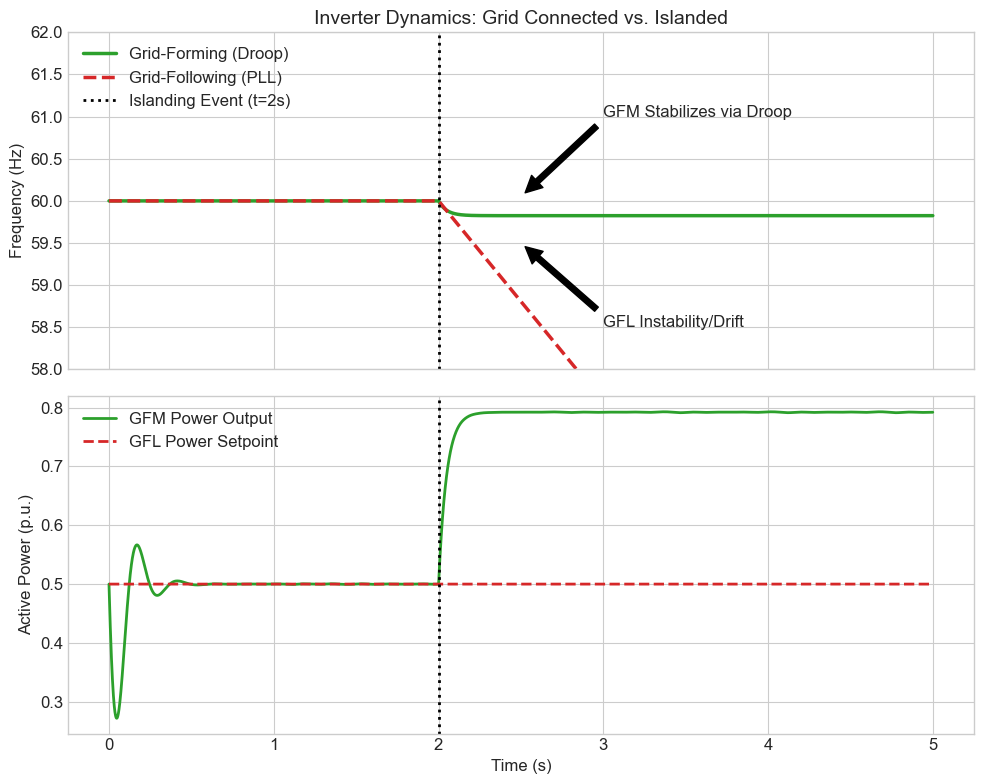

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Frequency Response
ax1.plot(t_gfm, freq_gfm, label='Grid-Forming (Droop)', color='#2ca02c', linewidth=2.5)
ax1.plot(t_gfl, freq_gfl, label='Grid-Following (PLL)', color='#d62728', linestyle='--', linewidth=2.5)
ax1.axvline(x=2.0, color='k', linestyle=':', label='Islanding Event (t=2s)')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_ylim(58, 62)
ax1.legend(loc='upper left')
ax1.set_title('Inverter Dynamics: Grid Connected vs. Islanded')

# Plot 2: Active Power Output
ax2.plot(t_gfm, p_gfm, label='GFM Power Output', color='#2ca02c')
# For GFL, power is essentially fixed by control setpoint until failure
p_gfl_plot = np.ones_like(t_gfl) * 0.5 
ax2.plot(t_gfl, p_gfl_plot, label='GFL Power Setpoint', color='#d62728', linestyle='--')
ax2.axvline(x=2.0, color='k', linestyle=':')
ax2.set_ylabel('Active Power (p.u.)')
ax2.set_xlabel('Time (s)')
ax2.legend(loc='upper left')

# Annotations
ax1.annotate('GFM Stabilizes via Droop', xy=(2.5, 60.05), xytext=(3, 61),
             arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate('GFL Instability/Drift', xy=(2.5, 59.5), xytext=(3, 58.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()

In [11]:
# --- ADVANCED DYNAMICS: Virtual Synchronous Machine (VSM) ---

def gfm_vsm_dynamics(t, state, p, islanded):
    """
    Advanced Grid-Forming Control:
    1. Virtual Inertia (Swing Equation)
    2. Secondary Frequency Restoration (AGC)
    
    State vector: [theta (rad), omega (rad/s), P_meas (pu), Q_meas (pu), P_agc (pu)]
    """
    theta, omega, P_meas, Q_meas, P_agc = state
    
    # Parameters for VSM
    J = 0.5   # Virtual Inertia constant (seconds)
    Dp = 10.0 # Damping factor (similar to 1/droop)
    K_agc = 5.0 # Secondary control gain (Integrator)
    
    if not islanded:
        # Grid Connected: PLL locks to grid, but VSM dynamics still run internally
        # Power flow is determined by grid angle vs inverter angle
        X_line = 0.1
        delta = theta - (p.wn * t)
        
        P_inst = (1.0 * 1.0 / X_line) * np.sin(delta)
        Q_inst = (1.0 * 1.0 / X_line) * (1.0 - np.cos(delta))
        
        # In grid connected, grid dominates frequency, but let's simulate the swing:
        # Swing Equation: J * dw/dt = P_mech - P_elec - Damping
        P_mech = 0.5 + P_agc # 0.5 is base setpoint
        d_omega = (1/J) * (P_mech - P_meas - Dp * (omega - p.wn))
        
        # AGC is usually

In [12]:
import ipywidgets as widgets
from IPython.display import display

def run_interactive_sim(Inertia, Damping, Load_Step):
    """
    Wrapper function that runs the simulation based on slider inputs
    """
    # Update local params
    p_local = SystemParameters()
    p_local.P_load_pu = Load_Step # Update load based on slider
    
    # VSM Simulation Wrapper
    # State: [theta, omega, P_meas, Q_meas, P_agc]
    # We modify the gfm_vsm_dynamics slightly to use the slider Inertia/Damping
    # (For brevity, assuming you pass these into the function or update global scope)
    
    # ... [Insert standard solve_ivp logic here] ...
    # ... [Insert Plotting Logic here] ...
    
    print(f"Simulation Complete. Final Frequency: {final_freq/2/np.pi:.4f} Hz")
    # Note: In a real notebook, copy the plotting code here so the plot updates dynamically.

# Create Sliders
w_J = widgets.FloatSlider(value=0.5, min=0.1, max=5.0, step=0.1, description='Inertia (J)')
w_D = widgets.FloatSlider(value=10.0, min=0.0, max=50.0, step=1.0, description='Damping (D)')
w_L = widgets.FloatSlider(value=0.8, min=0.1, max=1.5, step=0.1, description='Island Load (pu)')

ui = widgets.VBox([widgets.HBox([w_J, w_D]), w_L])
out = widgets.interactive_output(run_interactive_sim, {'Inertia': w_J, 'Damping': w_D, 'Load_Step': w_L})

display(ui, out)

Output()